<a href="https://colab.research.google.com/github/shima2920/Kaggle/blob/main/Bike_Sharing_Demand_20210610.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#https://www.kaggle.com/general/74235

! pip install -q kaggle

from google.colab import files
files.upload()
#Kaggle account で発行した API token key ファイルを Upload する。

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

! kaggle competitions download -c bike-sharing-demand

Saving kaggle.json to kaggle.json
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-06-09 12:09:58           7175  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           4350  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1459  
mathurinache/twitter-edge-nodes                             Twitter Edge Nodes                                342MB  2021-03-08 06:43:04            481  
fatiimaezzahra/famous-iconic-women        

# 【Training】This is Kaggle Competition "Web Traffic Time Series Forecasting"



https://www.kaggle.com/c/bike-sharing-demand/overview


In [3]:
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder#Label Encoding
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb #LightLGBのハイパーパラメータチューニングモジュールであるOptunaをimport
import lightgbm as lgb_original
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import xgboost as XGBClassifier
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout #Dense : ニューラルネットの層を定義？
from keras.models import Sequential# 複雑なニューラルネットワークモデルを簡略化するためのモデルの一つであるSequentialモデル
from sklearn.preprocessing import StandardScaler #標準化



#Validation
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold


#イテレータ, ループ処理を実行してくれる
import itertools

pd.set_option("display.max_rows", 10000)
pd.set_option('display.max_columns', 1000)
%matplotlib inline

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sampleSubmission.csv')

# Check the train/test data

In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [8]:
print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (10886, 12)
Testing Features shape:  (6493, 9)


Data Field

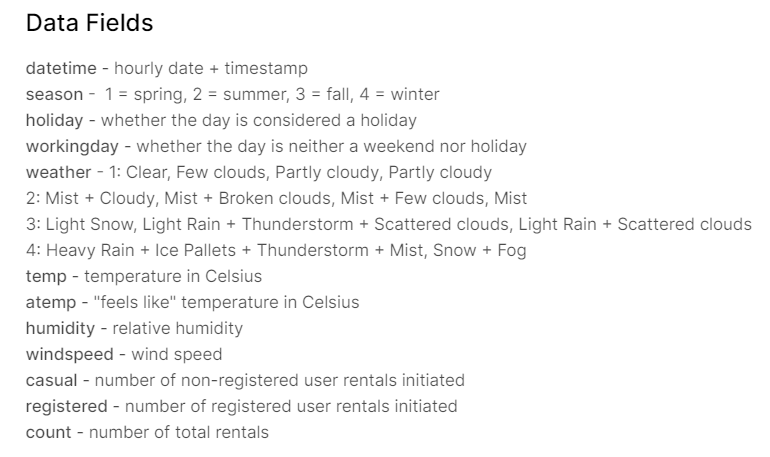

#Basic info

data summary


In [14]:
from scipy import stats
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [15]:
resumetable(train)[:25]

Dataset Shape: (10886, 12)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,datetime,object,0,10886,2011-01-01 00:00:00,2011-01-01 01:00:00,2011-01-01 02:00:00,13.41
1,season,int64,0,4,1,1,1,2.00
2,holiday,int64,0,2,0,0,0,0.19
3,workingday,int64,0,2,0,0,0,0.90
4,weather,int64,0,4,1,1,1,1.19
5,temp,float64,0,49,9.84,9.02,9.02,5.18
6,atemp,float64,0,60,14.395,13.635,13.635,5.37
7,humidity,int64,0,89,81,80,80,6.01
8,windspeed,float64,0,28,0,0,0,3.83
9,casual,int64,0,309,3,8,5,6.43


In [16]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


missing value

In [18]:
#train
total = train.isnull().sum().sort_values(ascending=False)
percent = ((train.isnull().sum()/train.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(434)

,Total,Percent
count,0,0.0
registered,0,0.0
casual,0,0.0
windspeed,0,0.0
humidity,0,0.0
atemp,0,0.0
temp,0,0.0
weather,0,0.0
workingday,0,0.0
holiday,0,0.0


In [19]:
#Test
total = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(100)

,Total,Percent
windspeed,0,0.0
humidity,0,0.0
atemp,0,0.0
temp,0,0.0
weather,0,0.0
workingday,0,0.0
holiday,0,0.0
season,0,0.0
datetime,0,0.0


no missing value in train and test data

## EDA

show the histogram for count column

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


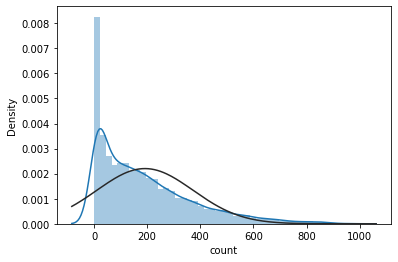

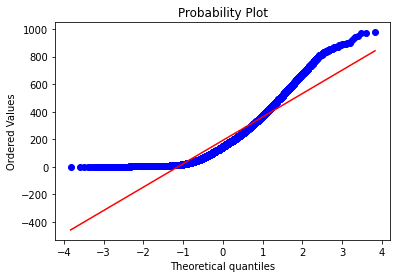

In [13]:
from scipy.stats import norm
#ヒストグラム表示(正規分布込)
from scipy import stats
#histogram and normal probability plot
var = 'count'
sns.distplot(train[var], fit=norm);
fig = plt.figure()
res = stats.probplot(train[var], plot=plt)

correlation

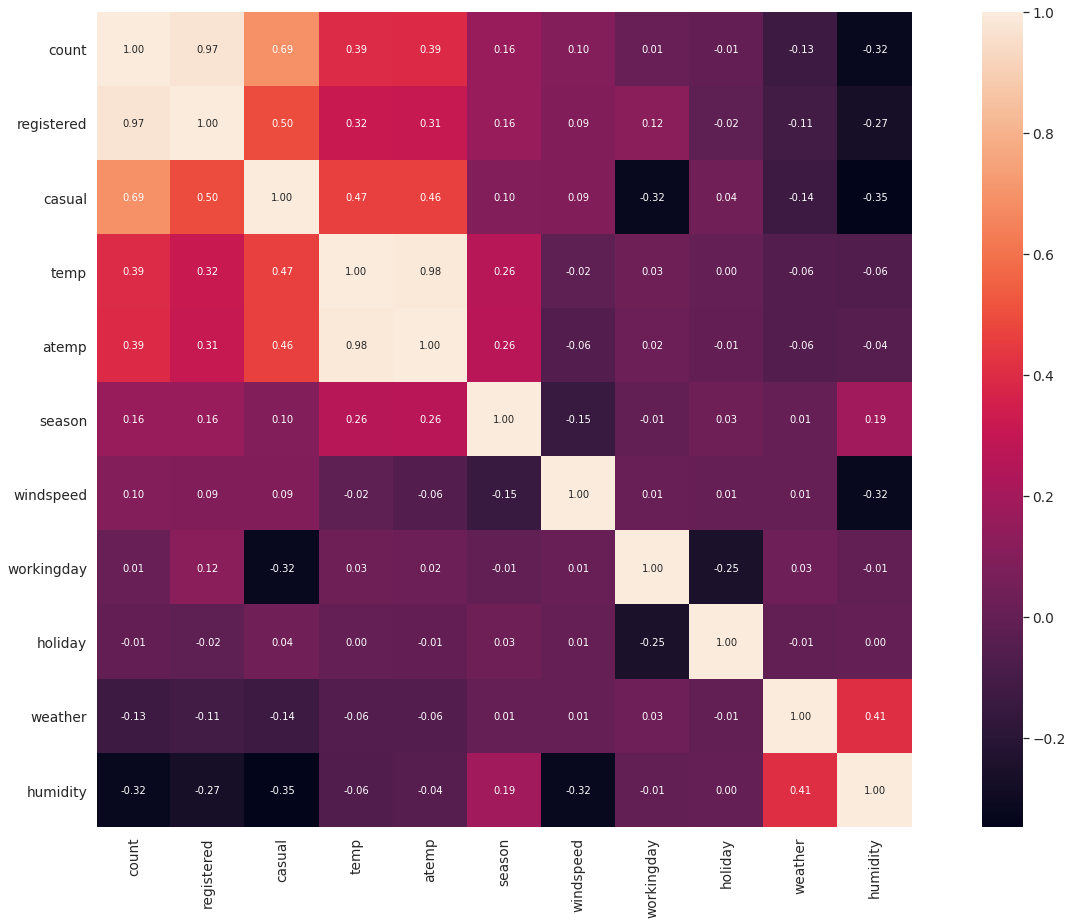

In [21]:
#correlation matrix
plt.figure(figsize=(25,15))
k = len(train.columns) #number of variables for heatmap
corrmat = train.corr()
cols = corrmat.nlargest(k, 'count')['count'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Drop the below columns.

*   atemp : It is not accurate data, so its better to delete it.
*   workingday : i wonder why its has a low correlation with count, but decide to delete it.
*   holiday : same reason with workingday








In [22]:
train = train.drop(['atemp','workingday','holiday'], axis = 1)
test = test.drop(['atemp','workingday','holiday'], axis = 1)